In [19]:
%reload_ext autoreload
%autoreload 2

import torch
from torch.utils.data import DataLoader
from DatasetClass import KITTI_MOD_FIXED, ExtendedKittiMod, CarlaMotionSeg
from torch.nn import Sigmoid
# from torchmetrics import IoU
from sklearn.metrics import jaccard_score

# specify train/val and test datasets
## KITTI
# data_root = "/storage/remote/atcremers40/motion_seg/datasets/Extended_MOD_Masks/"
# dataset = ExtendedKittiMod(data_root)
## CARLA
data_root = "/storage/remote/atcremers40/motion_seg/datasets/Carla_Annotation/Carla_Export/"
dataset = CarlaMotionSeg(data_root)

# specify train/val split (make sure this is equal to train.py)
batch_size = 2
dataset_fraction = 1.0
dataset_length = int(len(dataset) * dataset_fraction)
train_size = int(0.6 *  dataset_length)
val_size = int(0.5*(dataset_length - train_size))
test_size = dataset_length - train_size - val_size
# taking subset of dataset according to dataset_fraction
dataset_idx = list(range(0, dataset_length))
dataset = torch.utils.data.Subset(dataset, dataset_idx)
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size], generator = torch.Generator().manual_seed(0))
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)


model_path = "/storage/remote/atcremers40/motion_seg/saved_models/01-02-2022_18-30_bs2/best_aIoU.pt"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model = torch.load(model_path).to(device)

def calc_iou_moving(outputs: torch.Tensor, labels: torch.Tensor):
    SMOOTH = 1e-6
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1)
    
    intersection = torch.sum(torch.bitwise_and(outputs, labels).float(), (1,2))  # Will be zero if Truth=0 or Prediction=0
    union = torch.sum(torch.bitwise_or(outputs, labels).float(), (1,2))          # Will be zero if both are 0
    
    IoU = (intersection + SMOOTH) / (union + SMOOTH)   # avoid division by zero
    IoU = IoU.mean()
        
    return IoU

def calc_iou_background(outputs: torch.Tensor, labels: torch.Tensor):
    SMOOTH = 1e-6
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1)

    outputs = (outputs -1) * -1
    labels = (labels -1) * -1
    
    intersection = torch.sum(torch.bitwise_and(outputs, labels).float(), (1,2))  # Will be zero if Truth=0 or Prediction=0
    union = torch.sum(torch.bitwise_or(outputs, labels).float(), (1,2))          # Will be zero if both are 0
    
    IoU = (intersection + SMOOTH) / (union + SMOOTH)   # avoid division by zero
    IoU = IoU.mean()
        
    return IoU

def aIoU(outputs: torch.Tensor, labels: torch.Tensor):
    iou_moving = calc_iou_moving(outputs, labels)
    iou_background = calc_iou_background(outputs, labels)
    aIoU = (iou_moving + iou_background)/2
    return aIoU


def confusion_matrix(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1)
    labels = labels.squeeze(1)

    TP = torch.sum(torch.bitwise_and(outputs, labels).float(), (1,2)) # intersection
    FP = torch.sum(outputs,(1,2)) - TP
    FN = torch.sum(labels, (1,2)) - TP
    TN = torch.sum(labels, (1,2)) - torch.sum(torch.bitwise_or(outputs, labels).float(), (1,2)) # union

    return TP, FP, TN, FN

def test(loader):
    sigmoid = Sigmoid()
    with torch.no_grad():
        model.eval()
        test_iou = []
        for idx, (data, targets) in enumerate(loader):
            data = data.to(device).float()
            targets = targets.to(device).int()

            # forward
            scores = model(data)
            scores_rounded = torch.round(sigmoid(scores)).int()
            # iou_moving = calc_iou_moving(scores_rounded, targets)
            # iou_background = calc_iou_background(scores_rounded, targets)
            # test_iou.append((iou_moving + iou_background)/2)
            # test_iou.append(aIoU(scores_rounded, targets))

            test_iou.append(calc_iou_moving(scores_rounded, targets))

    model.train()
    print(f"aIoU: {sum(test_iou)/len(test_iou)}")

test(val_loader)

dirs loaded:
['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025']
aIoU: 0.1987573206424713


## Visualize sample images

First IoU: 0.7536098957061768
Second IoU: 0.7776119112968445


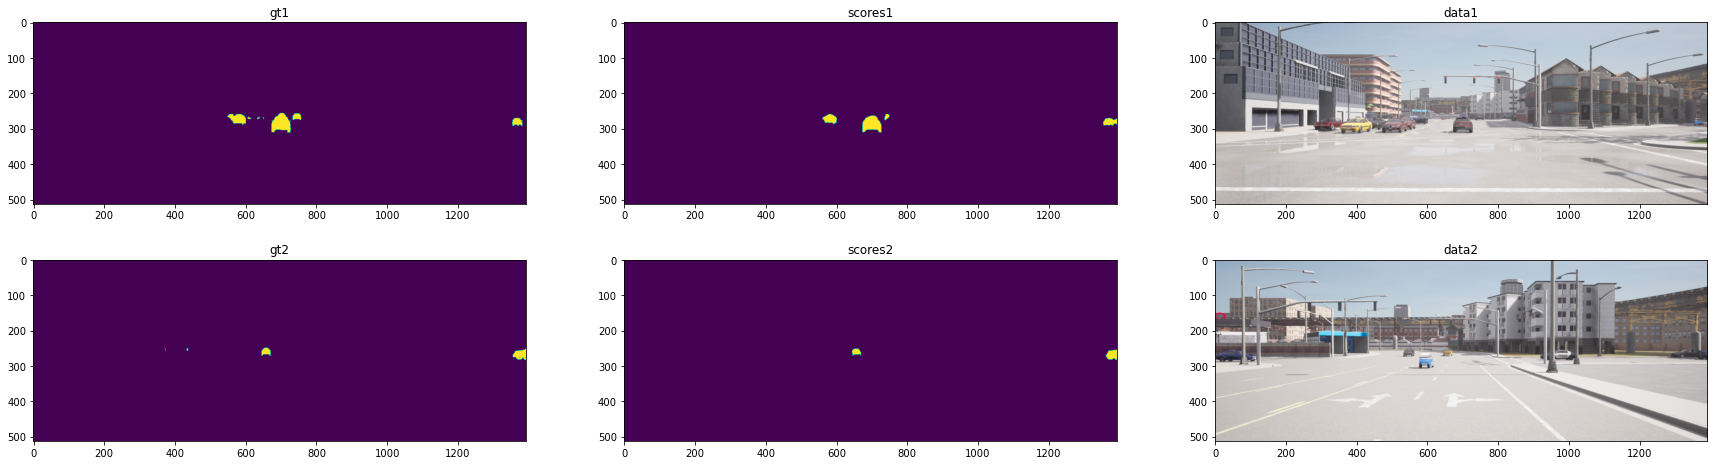

In [39]:
"""
visualizes a random batch from the specified dataset
"""
# set dataset and model
loader = val_loader
model_path = "/storage/remote/atcremers40/motion_seg/saved_models/02-02-2022_08-21_bs2/best_aIoU.pt"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = torch.load(model_path).to(device)

import matplotlib.pyplot as plt
import numpy as np
sigmoid = Sigmoid()

# get data from data_loader
data, targets = next(iter(loader))
data = data.to(device)
targets = targets.to(device)

# forward pass through NN
scores = model(data)

# pass to CPU for visualization
scores = scores.detach().cpu()
targets = targets.detach().cpu()
data = data.detach().cpu()
scores_rounded = torch.round(sigmoid(scores)).int()
targets = targets.int()

print(f"First IoU: {calc_iou_moving(scores_rounded[0], targets[0])}")
print(f"Second IoU: {calc_iou_moving(scores_rounded[1], targets[1])}")

# plotting
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(30, 8))
ax1.imshow(targets[0][0])
ax1.set_title("gt1")
ax2.imshow(scores_rounded.detach().numpy()[0][0])
ax2.set_title("scores1")
ax3.imshow(np.transpose(data[0][:3], axes=[1, 2, 0]))
ax3.set_title("data1")
ax4.imshow(targets[1][0])
ax4.set_title("gt2")
ax5.imshow(scores_rounded.detach().numpy()[1][0])
ax5.set_title("scores2")
ax6.imshow(np.transpose(data[1][:3], axes=[1, 2, 0]))
ax6.set_title("data2")
plt.show()

## Pre-computing mean and std of train set

In [23]:
import torch
from torch.utils.data import DataLoader
from DatasetClass import KITTI_MOD_FIXED, ExtendedKittiMod
import numpy as np

data_root = "/storage/remote/atcremers40/motion_seg/datasets/Extended_MOD_Masks/"
dataset = ExtendedKittiMod(data_root, test=False)
batch_size = 2
loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

channel_means = []
channel_std = []
for i,(data, _) in enumerate(loader):
    # calc mean
    channel_means.append([data[:,i,:,:].mean().item() for i in range(3)])
    # calc std
    channel_std.append([data[:,i,:,:].std().item() for i in range(3)])

mean = np.array(channel_means).sum(0)/len(channel_means)
std = np.array(channel_std).sum(0)/len(channel_std)
print(mean)
print(std)

dirs loaded:
['2011_09_26_drive_0005_sync', '2011_09_26_drive_0013_sync', '2011_09_26_drive_0014_sync', '2011_09_26_drive_0015_sync', '2011_09_26_drive_0018_sync', '2011_09_26_drive_0032_sync', '2011_09_26_drive_0051_sync', '2011_09_26_drive_0056_sync', '2011_09_26_drive_0057_sync', '2011_09_26_drive_0059_sync', '2011_09_26_drive_0060_sync']
[0.40637735 0.4300676  0.42383534]
[0.31099932 0.322008   0.33540214]
